# Description

Goals : Melakukan prediksi terhadap suatu gambar apakah termasuk kategori Rock, Paper atau Scissor. 

Created by : A.Rofiqi Maulana

Metode yang populer yang bisa digunakan untuk memprediksi gambar adalah Convolutional Neural Network (CNN). Algoritma ini populer digunakan pada kasus computer vision karena seolah-olah meniru kemampuan mamalia melihat yaitu terletak pada penggunaan filter dan Maxpooling (mengambil pattern objek yang penting atau unik).

Tahapan dari metode ini adalah
1. Data Preparation
2. Modeling
3. Evaluation
4. Prediction

# Data Preparation

Pada dasarnya, terdapat perbedaan cara melihat gambar antara manusia dan mesin. mesin melihat suatu gambar melalui barisan angka, begitu juga jenis warna (Read, Green atau Blue). Oleh karena itu data image yang kita punya perlu diterjemahkan ke format baru agar dia bisa dimengerti oleh mesin. Langkah-langkahnya sebagai berikut
1. Load data image ke Google Colab
2. Konversi data image ke dalam matriks 
3. Augmentasi Data

Langkah-langkah di atas sebenarnya bisa kita lakukan manual, namun package keras sudah menyediakan proses data preparation secara lebih mudah. Sehingga langkah-langkah data preparation menjadi
1. Organize file image menjadi beberapa folder dengan struktur
    ```
    Train____Rock
         ____Paper
         ____Scissor
    Test ____Rock
         ____Paper
         ____Scissor
    ```
2. Load data image berdasarkan mekanisme folder pada tahap (1) ke Google Collab
3. read data image untuk folder train
4. read data image untuk folder test

Augmentasi data adalah proses yang seolah-olah kita memeberikan sample training yang baru padahal sample baru training tersebut berasal dari data original. Beberapa teknik data augmentasi tersebut adalah
1. Translations
2. Rotations
3. Changes in scale
4. Shearing
5. Horizontal (and in some cases, vertical) flips


In [72]:
## Import Package
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import sys
import pathlib
import matplotlib.pyplot as plt
import numpy
import cv2
import tensorflow as tf
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from tensorflow import keras

Read dataset image ke google drive

In [2]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
## Lokasi data train dan data test
## Data sudah dibagi ke dalam data train dan data test dengan komposisi 70%,30%
## Proses pemisahan data dilakukan secara manual
dir_train = '/content/gdrive/My Drive/DATASET/Rock-Paper-Scissors/Train'
dir_test = '/content/gdrive/My Drive/DATASET/Rock-Paper-Scissors/Test'

In [55]:
## Generate batches of tensor image data with real-time data augmentation.
data_generator = ImageDataGenerator(
	rescale=1./225,
	rotation_range=20,
	horizontal_flip=True,
	shear_range=0.2,
	fill_mode='wrap'
	)


In [56]:
## Read the images for data train from a big numpy array and folders containing images.
data_train = data_generator.flow_from_directory(
        directory=dir_train,
        target_size=(100, 150),
        batch_size=32,
        shuffle=True
        )

Found 1533 images belonging to 3 classes.


In [57]:
## Read the images for data Test from a big numpy array and folders containing images.
data_test = data_generator.flow_from_directory(
	directory=dir_test,
  target_size=(100,150)
	)

Found 655 images belonging to 3 classes.


# Modeling

Arsitektur CNN yang digunakan pada kasus ini terdiri dari beberapa layer. Penentuan banyaknya layer berdasarkan penelitian sebelumnya maupun trial error, namun sebaiknya berangkat dari layer yang kecil terlebih dahulu. Akan diplih model **sequential** yang akan mengeksekusi layer-layer selanjutnya secara berurutan. Fungsi aktivasi yang dipilh pada layer-layer pertama dipilh relu, karena paling populer. Juga digunakan **MaxPooling** agar pattern yang terambil bisa unik dan fokus pada spot yang penting sehingga komputasi lebih cepat. Pada layer terakhir dipilih fungsi aktivasi **softmax** karena terdapat tiga kategori. Jika banyaknya kategori =2 maka akan dipilih sigmoid. **Dropout** bisa juga ditambahkan untuk mengurangi kompleksitas karena mengeliminasi neuron secara random. **Callback** berfungsi untuk memilih model yang memiliki loss terendah (akurasi tertinggi), sehingga model yang digunakan adalah yang terbaik. Callback juga bisa menyaring model-model berdasarkan treshold loss yang kita tentukan.



In [60]:
## Define Sequential model 
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(100,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),  
  tf.keras.layers.Dropout(0.2),                                
  tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512,activation='relu'),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [61]:
## config the model with losses and metrics
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [75]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [77]:
## train the model 
history = model.fit(
    data_train,
    epochs=7,
    validation_data=data_test,
    validation_steps=4,
    verbose=2,
    callbacks=[EarlyStoppingAtMinLoss()]
)

Epoch 1/7
48/48 - 13s - loss: 0.0978 - accuracy: 0.9661 - val_loss: 0.0538 - val_accuracy: 0.9766
Epoch 2/7
48/48 - 13s - loss: 0.0800 - accuracy: 0.9739 - val_loss: 0.1933 - val_accuracy: 0.9219
Epoch 3/7
48/48 - 12s - loss: 0.0673 - accuracy: 0.9726 - val_loss: 0.1027 - val_accuracy: 0.9609
Epoch 4/7
48/48 - 13s - loss: 0.0621 - accuracy: 0.9739 - val_loss: 0.1118 - val_accuracy: 0.9531
Epoch 5/7
48/48 - 12s - loss: 0.0534 - accuracy: 0.9837 - val_loss: 0.0894 - val_accuracy: 0.9688
Epoch 6/7
Restoring model weights from the end of the best epoch.
48/48 - 13s - loss: 0.0591 - accuracy: 0.9739 - val_loss: 0.0766 - val_accuracy: 0.9766
Epoch 00006: early stopping


In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 148, 16)       448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 74, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 36, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 34, 64)       

# Evaluation

Evaluasi berfungsi untuk mengetahui performa model yang sudah dibentuk. Evaluasi yang digunakan adalah Akurasi, dan loss. Semakin tinggi akurasi maka model semakin bagus, semakin rendah loss maka model semakin bagus.

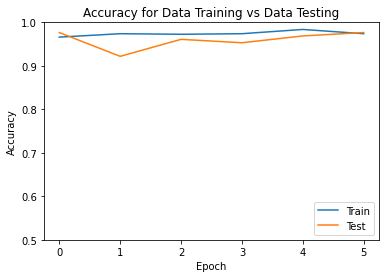

In [81]:
plt.title('Accuracy for Data Training vs Data Testing')
plt.plot(history.history['accuracy'], label = 'Train')
plt.plot(history.history['val_accuracy'], label = 'Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5,1)
plt.legend(loc='lower right')

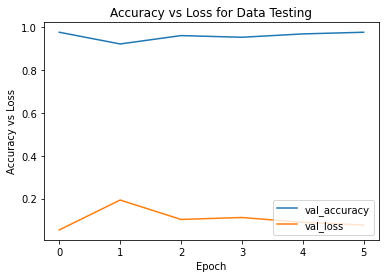

In [82]:
plt.title('Accuracy vs Loss for Data Testing')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy vs Loss')
plt.legend(loc='lower right')

Plot pertama menunjukkan bahwa akurasi data untuk data train dan data test semakin tinggi dan akurasinya lebi dari 90%. Pada plot kedua, nilai akurasi dan nilai loss berbanding terbalik. Jadi, berdasarkan kedua plot diatas dapat dikatakan bahwa tidak terdapat overfiting dan model layak digunakan untuk prediksi.

# Prediction

Kita akan coba membuat suatu function untuk melakukan prediksi dari model yang telah kita buat. Proses read file images akan menggunakan fasilitas uploading yang disediakan oleh google colab. Proses pada tahap ini adalah 

1. load dan read images
2. convert images to matriks
3. display images
4. make prediction 

Image yang telah di import akan diubah ke dalam bentuk array dan di formatnya diubah sedemikian hingga bisa digunakan sebagai input untuk melakukan prediksi. label prediction urutannya sebagaimana urutan saat data images di import.

In [86]:
## Fungsi untuk membuat prediksi suatu gambar
def MakingPrediction(path,model):
  prediction = ''
  img = image.load_img(path,target_size=(100,150))
  x = image.img_to_array(img)
  x = np.expand_dims(x,axis=0)
  
  prediction_value = model.predict(x)

  if prediction_value[0][0]==1:
    prediction = 'paper'
  elif prediction_value[0][1]==1:
    prediction = 'rock'
  elif prediction_value[0][2]==1:
    prediction = 'scissor'
  else:
    prediction_value = 'NA'
  return prediction

In [95]:
## Read Data
from google.colab import files
uploaded = files.upload()
pathImages = list(uploaded.keys())[0] #mendapatkan path atau nama file image
img = image.load_img(pathImages)

Saving eJ5fbY23rZWUULxO.png to eJ5fbY23rZWUULxO (4).png


'rock'

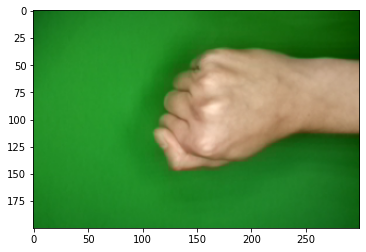

In [96]:
## Menampilkan images dan hasil prediksinya
plt.imshow(img)
MakingPrediction(pathImages,model)

Refference
1. https://keras.io/api/preprocessing/image/
2. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image
3. https://www.tensorflow.org/guide/keras/train_and_evaluate
4. https://www.tensorflow.org/guide/keras/custom_callback